In [1]:
import pandas as pd
import numpy as np
import glob
import torchaudio
from torchaudio import transforms
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
METADATA_FILE = 'data/metadata_compiled.csv'

metadata_df = pd.read_csv(METADATA_FILE)
metadata_df.head()

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,7.326171,48.9,2.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,male,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0012c608-33d0-4ef7-bde3-75a0b1a0024e,2020-04-15T01:03:59.029326+00:00,0.0482,0.000000,-16.5,-71.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
metadata_df.columns

Index(['uuid', 'datetime', 'cough_detected', 'SNR', 'latitude', 'longitude',
       'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status',
       'quality_1', 'cough_type_1', 'dyspnea_1', 'wheezing_1', 'stridor_1',
       'choking_1', 'congestion_1', 'nothing_1', 'diagnosis_1', 'severity_1',
       'quality_2', 'cough_type_2', 'dyspnea_2', 'wheezing_2', 'stridor_2',
       'choking_2', 'congestion_2', 'nothing_2', 'diagnosis_2', 'severity_2',
       'quality_3', 'cough_type_3', 'dyspnea_3', 'wheezing_3', 'stridor_3',
       'choking_3', 'congestion_3', 'nothing_3', 'diagnosis_3', 'severity_3',
       'quality_4', 'cough_type_4', 'dyspnea_4', 'wheezing_4', 'stridor_4',
       'choking_4', 'congestion_4', 'nothing_4', 'diagnosis_4', 'severity_4'],
      dtype='object')

In [22]:
not_nan_df = metadata_df[metadata_df['status'].isna() == False]
filtered_df = not_nan_df[not_nan_df['cough_detected'] > 0.5]
filtered_df[['uuid', 'cough_detected', 'SNR', 'age', 'gender', 'status']]

,uuid,cough_detected,SNR,age,gender,status
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,0.9609,16.151433,15.0,male,healthy
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,0.9301,20.146058,34.0,male,healthy
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,0.9968,13.146502,21.0,male,healthy
8,001e2f19-d81c-4029-b33c-d2db56b23a4a,0.7811,12.566406,20.0,male,healthy
10,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,0.8937,13.477551,28.0,female,healthy
...,...,...,...,...,...,...
27541,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,0.5591,11.209351,26.0,male,healthy
27542,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,1.0000,33.661082,23.0,male,healthy
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,0.9784,9.635425,22.0,female,healthy
27544,fff13fa2-a725-49ef-812a-39c6cedda33d,0.7154,14.162062,21.0,male,healthy


In [23]:
metadata_df['status'].value_counts()

healthy        12479
symptomatic     2590
COVID-19        1155
Name: status, dtype: int64

In [24]:
filtered_df['status'].value_counts()

healthy        9774
symptomatic    2082
COVID-19        782
Name: status, dtype: int64

In [71]:
BASE_PATH = 'data/'
def get_audio_file(uuid, data_path=BASE_PATH):
    results = glob.glob(data_path + uuid + '.*')
    for result in results:
        ext = result.split('.')[1]
        if ext in ['ogg', 'webm']:
            return result
    else:
        raise Exception('No audio file found for uuid: {}'.format(uuid))


def load_audio_file(uuid):
    audio_file = get_audio_file(uuid)
    
    sig, sr = torchaudio.load(audio_file)
    info = torchaudio.info(audio_file)
    
    return sig, sr, info
    
uuid, cough_detected, status = filtered_df[['uuid', 'cough_detected', 'status']].iloc[np.random.randint(0, len(filtered_df))]

sig, sr, info = load_audio_file(uuid)

print('Sample rate: {} Hz'.format(sr))
print('Duration: {} s'.format(info.num_frames / info.sample_rate))
print('Channels: {}'.format(info.num_channels))

print('Cough detected: {}'.format(cough_detected))
print('Status: {}'.format(status))

Sample rate: 48000 Hz
Duration: 9.06 s
Channels: 1
Cough detected: 0.6141
Status: healthy


In [72]:
Audio(sig[0].numpy(), rate=sr)

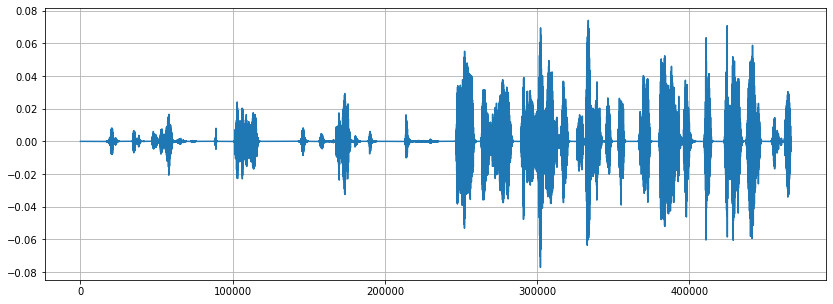

In [8]:
fig = plt.figure(figsize=(14, 5))
plt.plot(sig.t().numpy())
plt.grid()

plt.show()

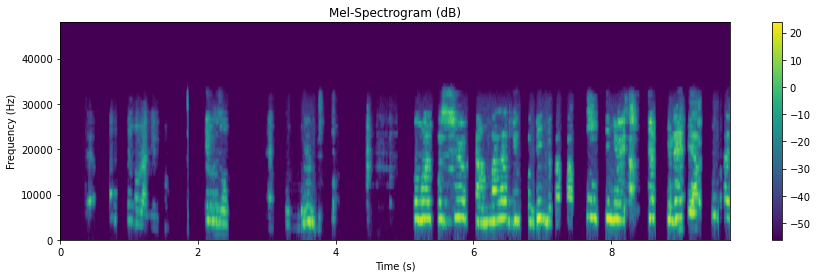

In [9]:
spec = transforms.MelSpectrogram(sr, n_fft=1024, n_mels=64)(sig)
spec = transforms.AmplitudeToDB(top_db=80)(spec)

fig, axs = plt.subplots(1, 1, figsize=(15, 4))

axs.set_title('Mel-Spectrogram (dB)')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Frequency (Hz)')

im = axs.imshow(spec[0], origin='lower', aspect='auto', extent=(0, sig[0].shape[0] / sr, 0, sr))
fig.colorbar(im, ax=axs)

plt.show(block=False)

In [11]:
spec[0].shape

torch.Size([64, 912])